In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
using Plots, BenchmarkTools
using JPEC.SplinesMod

  Activating project at `c:\Users\thlmi\OneDrive\바탕 화면\서울대\대학원\codes\JPEC\JPEC-github0708\JPEC`
Precompiling project...
    713.8 ms  ✓ JPEC
  1 dependency successfully precompiled in 3 seconds. 183 already precompiled.


---- Performance comparison ----

allocating (`spline_eval` VEC→MAT):
  65.800 μs (2004 allocations: 93.88 KiB)

in-place (`spline_eval!` loop):
  50.800 μs (0 allocations: 0 bytes)

external scalar (`spline_eval` loop):
  134.200 μs (2000 allocations: 78.12 KiB)


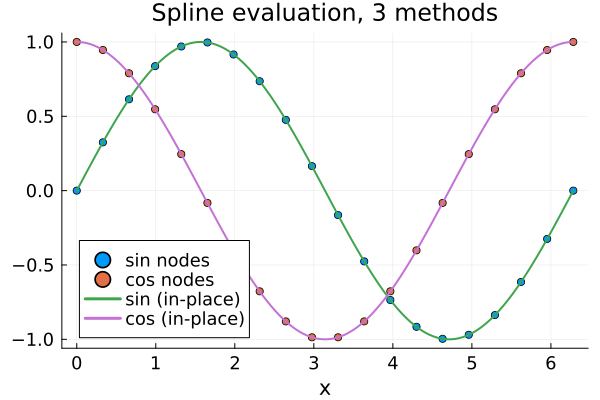

In [2]:

# ----------------------------- 1. setup -----------------------------
xs  = range(0, 2π; length=20) |> collect
fs  = sin.(xs)
fc  = cos.(xs)
spline = spline_setup(xs, hcat(fs, fc), 2)

xs_fine = range(0, 2π; length=1_000) |> collect
n_fine  = length(xs_fine)

println("---- Performance comparison ----")

# ------------------------- 2-A. external vector -------------------------
function run_alloc_eval(spl, xs)
    spline_eval(spl, xs)   # Assign matrices at once
end
println("\nallocating (`spline_eval` VEC→MAT):")
@btime run_alloc_eval($spline, $xs_fine);

# ------------------------- 2-B. in-place ---------------------------
function run_inplace_eval(spl, xs, out)
    @inbounds for (i, x) in enumerate(xs)
        spline_eval!(spl, x, 0)     # result is spl.f
        @views out[i, :] .= spl.f                   
    end
    return out
end
out_inplace = Matrix{Float64}(undef, n_fine, spline.nqty)
println("\nin-place (`spline_eval!` loop):")
@btime run_inplace_eval($spline, $xs_fine, $out_inplace);

# ------------------------- 2-C. external(one-by-one) ---------------
function run_external_scalar(spl, xs, out)
    @inbounds for (i, x) in enumerate(xs)
        out[i, :] .= spline_eval(spl, x)
    end
    return out
end
out_scalar = Matrix{Float64}(undef, n_fine, spline.nqty)
println("\nexternal scalar (`spline_eval` loop):")
@btime run_external_scalar($spline, $xs_fine, $out_scalar);

# ------------------------- 3. Validation & Visualization ------------------------
@assert isapprox(out_inplace, out_scalar) 
@assert isapprox(out_inplace, run_alloc_eval(spline, xs_fine))


default(titlefont = font(16), guidefont = font(14),
        tickfont = font(12),  legendfont = font(12))  

p = plot(xs,  [fs fc]; seriestype = :scatter,
         label = ["sin nodes" "cos nodes"],
         title = "Spline evaluation, 3 methods",
         xlabel = "x")
plot!(p, xs_fine, out_inplace,
      label = ["sin (in-place)" "cos (in-place)"], lw = 2)
display(p)




== 2. Complex CubicSpline Performance Test ==

---- Performance comparison for Complex CubicSpline ----

Allocating (`spline_eval` with vector):
  120.100 μs (5004 allocations: 234.51 KiB)

In-place (`spline_eval!` in a loop):
  101.300 μs (0 allocations: 0 bytes)

Allocating scalar (`spline_eval` in a loop):
  154.300 μs (5000 allocations: 218.75 KiB)


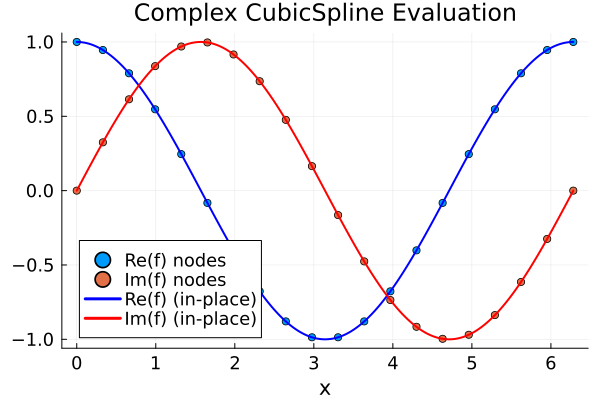

In [3]:
println("\n\n==============================================")
println("== 2. Complex CubicSpline Performance Test ==")
println("==============================================")

# ----------------------------- 2.1. Setup -----------------------------
xs_ccs     = range(0, 2π; length=20) |> collect
# Define a complex function: f(x) = exp(im*x) = cos(x) + i*sin(x)
fs_ccs = exp.(im .* xs_ccs) 

# Create a complex spline with one quantity
spline_ccs = spline_setup(xs_ccs, fs_ccs, 2) # Use periodic b.c.

xs_ccs_fine = range(0, 2π; length=1_000) |> collect
n_ccs_fine  = length(xs_ccs_fine)

println("\n---- Performance comparison for Complex CubicSpline ----")

# -------------------- 2.2-A. Allocating (Vector -> Matrix) --------------------
function run_ccs_alloc_vec(spl, xs)
    spline_eval(spl, xs)
end
println("\nAllocating (`spline_eval` with vector):")
@btime run_ccs_alloc_vec($spline_ccs, $xs_ccs_fine);

# ----------------------- 2.2-B. In-place Evaluation ------------------------
function run_ccs_inplace(spl, xs, out)
    @inbounds for (i, x) in enumerate(xs)
        spline_eval!(spl, x, 0) # result stored in spl.f
        @views out[i, :] .= spl.f
    end
    return out
end
out_ccs_inplace = Matrix{ComplexF64}(undef, n_ccs_fine, spline_ccs.nqty)
println("\nIn-place (`spline_eval!` in a loop):")
@btime run_ccs_inplace($spline_ccs, $xs_ccs_fine, $out_ccs_inplace);

# ------------------- 2.2-C. Allocating (Scalar in loop) --------------------
function run_ccs_alloc_scalar(spl, xs, out)
    @inbounds for (i, x) in enumerate(xs)
        out[i, :] .= spline_eval(spl, x)
    end
    return out
end
out_ccs_scalar = Matrix{ComplexF64}(undef, n_ccs_fine, spline_ccs.nqty)
println("\nAllocating scalar (`spline_eval` in a loop):")
@btime run_ccs_alloc_scalar($spline_ccs, $xs_ccs_fine, $out_ccs_scalar);

# -------------------- 2.3. Validation & Visualization --------------------
@assert isapprox(out_ccs_inplace, out_ccs_scalar)
@assert isapprox(out_ccs_inplace, run_ccs_alloc_vec(spline_ccs, xs_ccs_fine))

# Separate the real and imaginary parts for plotting
real_part = real.(out_ccs_inplace)
imag_part = imag.(out_ccs_inplace)

p_ccs = plot(xs_ccs, real.(fs_ccs); seriestype=:scatter,
             label="Re(f) nodes",
             title="Complex CubicSpline Evaluation",
             xlabel="x", legend=:bottomleft)
plot!(p_ccs, xs_ccs, imag.(fs_ccs); seriestype=:scatter,
      label="Im(f) nodes")

plot!(p_ccs, xs_ccs_fine, real_part,
      label="Re(f) (in-place)", lw=2, color=:blue)
plot!(p_ccs, xs_ccs_fine, imag_part,
      label="Im(f) (in-place)", lw=2, color=:red)
      
display(p_ccs)



== 3. BicubicSpline Performance Test ==

---- Performance comparison for BicubicSpline ----

Allocating (`bicube_eval` with vectors):
  55.172 ms (600004 allocations: 18.69 MiB)

In-place (`bicube_eval!` in a loop):
  49.639 ms (0 allocations: 0 bytes)

Allocating scalar (`bicube_eval` in a loop):
  62.602 ms (600000 allocations: 18.31 MiB)


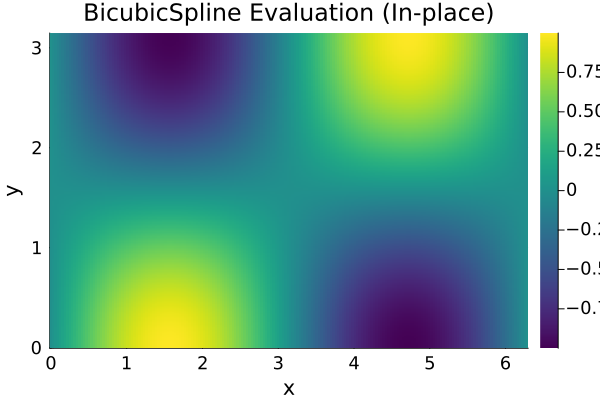

In [4]:
println("\n\n========================================")
println("== 3. BicubicSpline Performance Test ==")
println("========================================")

# ----------------------------- 3.1. Setup -----------------------------
xs_bc = range(0, 2π; length=20) |> collect
ys_bc = range(0, π;  length=25) |> collect
# Define a 2D function and create the 3D data array (mx, my, nqty)
fs_bc = [sin(x) * cos(y) for x in xs_bc, y in ys_bc, _ in 1:1] 

bicube = bicube_setup(xs_bc, ys_bc, fs_bc)

xs_bc_fine = range(0, 2π; length=200) |> collect
ys_bc_fine = range(0, π;  length=250) |> collect
nx_bc_fine, ny_bc_fine = length(xs_bc_fine), length(ys_bc_fine)

println("\n---- Performance comparison for BicubicSpline ----")

# -------------------- 3.2-A. Allocating (Vectors -> 3D Array) --------------------
function run_bc_alloc_vec(spl, xs, ys)
    bicube_eval(spl, xs, ys)
end
println("\nAllocating (`bicube_eval` with vectors):")
@btime run_bc_alloc_vec($bicube, $xs_bc_fine, $ys_bc_fine);

# ----------------------- 3.2-B. In-place Evaluation ------------------------
function run_bc_inplace(spl, xs, ys, out)
    @inbounds for (j, y) in enumerate(ys), (i, x) in enumerate(xs)
        bicube_eval!(spl, x, y, 0)
        @views out[i, j, :] .= spl.f
    end
    return out
end
out_bc_inplace = Array{Float64, 3}(undef, nx_bc_fine, ny_bc_fine, bicube.nqty)
println("\nIn-place (`bicube_eval!` in a loop):")
@btime run_bc_inplace($bicube, $xs_bc_fine, $ys_bc_fine, $out_bc_inplace);

# ------------------- 3.2-C. Allocating (Scalar in loop) --------------------
function run_bc_alloc_scalar(spl, xs, ys, out)
    @inbounds for (j, y) in enumerate(ys), (i, x) in enumerate(xs)
        out[i, j, :] .= bicube_eval(spl, x, y)
    end
    return out
end
out_bc_scalar = Array{Float64, 3}(undef, nx_bc_fine, ny_bc_fine, bicube.nqty)
println("\nAllocating scalar (`bicube_eval` in a loop):")
@btime run_bc_alloc_scalar($bicube, $xs_bc_fine, $ys_bc_fine, $out_bc_scalar);


# -------------------- 3.3. Validation & Visualization --------------------
@assert isapprox(out_bc_inplace, out_bc_scalar)
@assert isapprox(out_bc_inplace, run_bc_alloc_vec(bicube, xs_bc_fine, ys_bc_fine))

p_bc = heatmap(xs_bc_fine, ys_bc_fine, out_bc_inplace[:,:,1]',
               title="BicubicSpline Evaluation (In-place)",
               xlabel="x", ylabel="y",
               c=:viridis)
display(p_bc)



== 4-1. FourierSpline Performance Test (Fit1)==

---- Performance comparison for FourierSpline ----

Allocating (`fspline_eval` with vectors):
  95.489 ms (100003 allocations: 3.43 MiB)

In-place (`fspline_eval!` in a loop):
  84.445 ms (0 allocations: 0 bytes)

Allocating scalar (`fspline_eval` in a loop):
  106.220 ms (250000 allocations: 9.92 MiB)


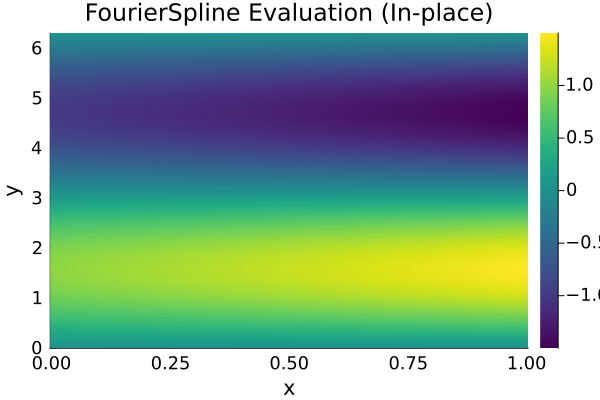

In [5]:
println("\n\n========================================")
println("== 4-1. FourierSpline Performance Test (Fit1)==")
println("========================================")

# ----------------------------- 4-1.1. Setup -----------------------------
xs_fs = range(0, 1.0; length=20) |> collect
# For FFT (method 2), length(ys)-1 must be a power of 2. 33 -> 32 intervals.
ys_fs = range(0, 2π; length=33) |> collect 
# A function with spline behavior in x and periodic in y
fs_fs = [(1 + 0.5*x) * sin(y) for x in xs_fs, y in ys_fs, _ in 1:1]

# Using fit_method=2 (FFT) and mband=10 Fourier modes
fourier = fspline_setup(xs_fs, ys_fs, fs_fs, 10; bctype=4, fit_method=1)

xs_fs_fine = range(0, 1.0; length=200) |> collect
ys_fs_fine = range(0, 2π;  length=250) |> collect
nx_fs_fine, ny_fs_fine = length(xs_fs_fine), length(ys_fs_fine)

println("\n---- Performance comparison for FourierSpline ----")

# -------------------- 4-1.2-A. Allocating (Vectors -> 3D Array) --------------------
function run_fs_alloc_vec(spl, xs, ys)
    fspline_eval(spl, xs, ys)
end
println("\nAllocating (`fspline_eval` with vectors):")
@btime run_fs_alloc_vec($fourier, $xs_fs_fine, $ys_fs_fine);

# ----------------------- 4-1.2-B. In-place Evaluation ------------------------
function run_fs_inplace(spl, xs, ys, out)
    @inbounds for (j, y) in enumerate(ys), (i, x) in enumerate(xs)
        fspline_eval!(spl, x, y, 0)
        @views out[i, j, :] .= spl.f
    end
    return out
end
out_fs_inplace = Array{Float64, 3}(undef, nx_fs_fine, ny_fs_fine, fourier.nqty)
println("\nIn-place (`fspline_eval!` in a loop):")
@btime run_fs_inplace($fourier, $xs_fs_fine, $ys_fs_fine, $out_fs_inplace);

# ------------------- 4-1.2-C. Allocating (Scalar in loop) --------------------
function run_fs_alloc_scalar(spl, xs, ys, out)
    @inbounds for (j, y) in enumerate(ys), (i, x) in enumerate(xs)
        out[i, j, :] .= fspline_eval(spl, x, y)
    end
    return out
end
out_fs_scalar = Array{Float64, 3}(undef, nx_fs_fine, ny_fs_fine, fourier.nqty)
println("\nAllocating scalar (`fspline_eval` in a loop):")
@btime run_fs_alloc_scalar($fourier, $xs_fs_fine, $ys_fs_fine, $out_fs_scalar);

# -------------------- 4-1.3. Validation & Visualization --------------------
@assert isapprox(out_fs_inplace, out_fs_scalar)
@assert isapprox(out_fs_inplace, run_fs_alloc_vec(fourier, xs_fs_fine, ys_fs_fine))

p_fs = heatmap(xs_fs_fine, ys_fs_fine, out_fs_inplace[:,:,1]',
               title="FourierSpline Evaluation (In-place)",
               xlabel="x", ylabel="y",
               c=:viridis)
display(p_fs)



== 4-2. FourierSpline Performance Test (Fit2)==

---- Performance comparison for FourierSpline ----

Allocating (`fspline_eval` with vectors):
  31.057 ms (100003 allocations: 3.43 MiB)

In-place (`fspline_eval!` in a loop):
  30.989 ms (0 allocations: 0 bytes)

Allocating scalar (`fspline_eval` in a loop):
  35.161 ms (250000 allocations: 9.92 MiB)


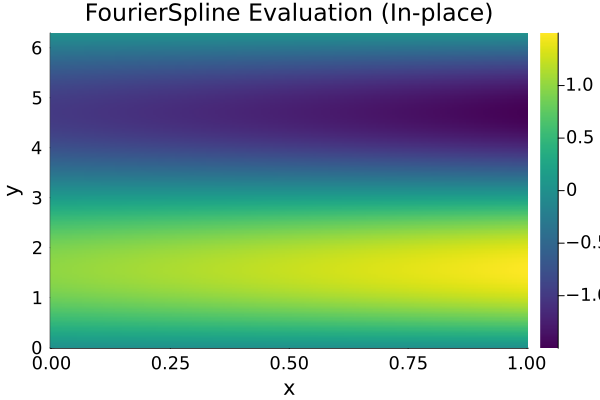

In [7]:
println("\n\n========================================")
println("== 4-2. FourierSpline Performance Test (Fit2)==")
println("========================================")

# ----------------------------- 4-2.1. Setup -----------------------------
xs_fs = range(0, 1.0; length=20) |> collect
# For FFT (method 2), length(ys)-1 must be a power of 2. 33 -> 32 intervals.
ys_fs = range(0, 2π; length=33) |> collect 
# A function with spline behavior in x and periodic in y
fs_fs = [(1 + 0.5*x) * sin(y) for x in xs_fs, y in ys_fs, _ in 1:1]

# Using fit_method=2 (FFT) and mband=10 Fourier modes
fourier = fspline_setup(xs_fs, ys_fs, fs_fs, 10; bctype=4, fit_method=2)

xs_fs_fine = range(0, 1.0; length=200) |> collect
ys_fs_fine = range(0, 2π;  length=250) |> collect
nx_fs_fine, ny_fs_fine = length(xs_fs_fine), length(ys_fs_fine)

println("\n---- Performance comparison for FourierSpline ----")

# -------------------- 4-2.2-A. Allocating (Vectors -> 3D Array) --------------------
function run_fs_alloc_vec(spl, xs, ys)
    fspline_eval(spl, xs, ys)
end
println("\nAllocating (`fspline_eval` with vectors):")
@btime run_fs_alloc_vec($fourier, $xs_fs_fine, $ys_fs_fine);

# ----------------------- 4-2.2-B. In-place Evaluation ------------------------
function run_fs_inplace(spl, xs, ys, out)
    @inbounds for (j, y) in enumerate(ys), (i, x) in enumerate(xs)
        fspline_eval!(spl, x, y, 0)
        @views out[i, j, :] .= spl.f
    end
    return out
end
out_fs_inplace = Array{Float64, 3}(undef, nx_fs_fine, ny_fs_fine, fourier.nqty)
println("\nIn-place (`fspline_eval!` in a loop):")
@btime run_fs_inplace($fourier, $xs_fs_fine, $ys_fs_fine, $out_fs_inplace);

# ------------------- 4-2.2-C. Allocating (Scalar in loop) --------------------
function run_fs_alloc_scalar(spl, xs, ys, out)
    @inbounds for (j, y) in enumerate(ys), (i, x) in enumerate(xs)
        out[i, j, :] .= fspline_eval(spl, x, y)
    end
    return out
end
out_fs_scalar = Array{Float64, 3}(undef, nx_fs_fine, ny_fs_fine, fourier.nqty)
println("\nAllocating scalar (`fspline_eval` in a loop):")
@btime run_fs_alloc_scalar($fourier, $xs_fs_fine, $ys_fs_fine, $out_fs_scalar);

# -------------------- 4-2.3. Validation & Visualization --------------------
@assert isapprox(out_fs_inplace, out_fs_scalar)
@assert isapprox(out_fs_inplace, run_fs_alloc_vec(fourier, xs_fs_fine, ys_fs_fine))

p_fs = heatmap(xs_fs_fine, ys_fs_fine, out_fs_inplace[:,:,1]',
               title="FourierSpline Evaluation (In-place)",
               xlabel="x", ylabel="y",
               c=:viridis)
display(p_fs)